In [2]:
# Step 1: Setup & Configuration

import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Configuration
IMG_SIZE = (224, 224)      # ResNet50 default input is >=224x224
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15         # Frozen base
EPOCHS_PHASE2 = 15         # Fine-tuning
NUM_CLASSES = 2            # appendicitis vs no appendicitis
VALIDATION_SPLIT = 0.2

# Paths
data_dir = 'images'        # base directory where images are stored
model_save_dir = 'saved_models_resnet'
os.makedirs(model_save_dir, exist_ok=True)

print("✅ Setup complete")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

✅ Setup complete
TensorFlow version: 2.15.0
GPU available: []


In [3]:
# Step 2: Data Preparation

from tensorflow.keras.applications.resnet import preprocess_input

# Data generators with preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.1,
    fill_mode='reflect',
    validation_split=VALIDATION_SPLIT
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT
)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\n✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {validation_generator.samples}")
print(f"✅ Classes: {train_generator.class_indices}")

Found 1378 images belonging to 2 classes.
Found 343 images belonging to 2 classes.

✅ Training samples: 1378
✅ Validation samples: 343
✅ Classes: {'appendicitis_images': 0, 'no_appendicitis_images': 1}


In [5]:
# Step 3: Model Creation (ResNet50 base + custom head)

# Create base model (ResNet50 pretrained on ImageNet)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,   # exclude default FC layers
    input_shape=(*IMG_SIZE, 3)
)

# Freeze base model initially (do transfer learning first)
base_model.trainable = False

# Custom classifier head
inputs = base_model.input
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile Phase 1 (frozen base model)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ ResNet50 model created (Phase 1: Frozen Base)")
model.summary()

✅ ResNet50 model created (Phase 1: Frozen Base)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
           

In [6]:
# Step 4: Phase 1 Training (Frozen Base)

# Callbacks
callbacks_phase1 = [
    ModelCheckpoint(
        os.path.join(model_save_dir, 'resnet_frozen_base_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("🚀 Starting Phase 1 Training (Frozen ResNet Base)...")

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=callbacks_phase1,
    verbose=1
)

# Save the model at the end of Phase 1
frozen_final_path = os.path.join(model_save_dir, 'resnet_frozen_base_final.keras')
model.save(frozen_final_path)

print(f"\n✅ Phase 1 complete. Model saved at {frozen_final_path}")
print(f"Best validation accuracy (Phase 1): {max(history_phase1.history['val_accuracy']):.4f}")

🚀 Starting Phase 1 Training (Frozen ResNet Base)...
Epoch 1/15
44/44 [==============================] - ETA: 0s - loss: 0.7440 - accuracy: 0.7235
Epoch 1: val_accuracy improved from -inf to 0.77843, saving model to saved_models_resnet/resnet_frozen_base_best.keras
44/44 [==============================] - 63s 1s/step - loss: 0.7440 - accuracy: 0.7235 - val_loss: 0.5001 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 2/15
44/44 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.7758
Epoch 2: val_accuracy did not improve from 0.77843
44/44 [==============================] - 69s 2s/step - loss: 0.5401 - accuracy: 0.7758 - val_loss: 0.4980 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 3/15
44/44 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.7772
Epoch 3: val_accuracy did not improve from 0.77843
44/44 [==============================] - 70s 2s/step - loss: 0.5257 - accuracy: 0.7772 - val_loss: 0.4978 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 4/15
44/44 [=

In [9]:
# Step 5: Phase 2 Training (Fine-tuning ResNet50)

print("🔓 Unfreezing last layers of ResNet50 for fine-tuning...")

# Unfreeze the base model
base_model.trainable = True  

# Fine-tune only the last 30 layers (keeps earlier layers frozen for stability)
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re‑compile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),   # smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"➡️ Fine-tuning from layer {fine_tune_at} onwards")
print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {np.sum([layer.trainable for layer in model.layers])}")

# Callbacks
callbacks_phase2 = [
    ModelCheckpoint(
        os.path.join(model_save_dir, 'resnet_finetuned_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

print("🚀 Starting Phase 2 Training (Fine-tuning ResNet50)...")

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=validation_generator,
    callbacks=callbacks_phase2,
    verbose=1
)

# Save final fine-tuned model
final_path = os.path.join(model_save_dir, 'resnet_finetuned_final.keras')
model.save(final_path)

print(f"\n✅ Phase 2 complete. Fine-tuned model saved at {final_path}")
print(f"Best validation accuracy (Phase 2): {max(history_phase2.history['val_accuracy']):.4f}")

🔓 Unfreezing last layers of ResNet50 for fine-tuning...
➡️ Fine-tuning from layer 145 onwards
Total layers: 7
Trainable layers: 6
🚀 Starting Phase 2 Training (Fine-tuning ResNet50)...
Epoch 1/15
44/44 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.7765
Epoch 1: val_accuracy improved from -inf to 0.77843, saving model to saved_models_resnet/resnet_finetuned_best.keras
44/44 [==============================] - 86s 2s/step - loss: 0.4778 - accuracy: 0.7765 - val_loss: 0.4509 - val_accuracy: 0.7784 - lr: 1.0000e-05
Epoch 2/15
44/44 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.7837
Epoch 2: val_accuracy did not improve from 0.77843
44/44 [==============================] - 82s 2s/step - loss: 0.4505 - accuracy: 0.7837 - val_loss: 0.4533 - val_accuracy: 0.7784 - lr: 1.0000e-05
Epoch 3/15
44/44 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.7830
Epoch 3: val_accuracy did not improve from 0.77843
44/44 [================

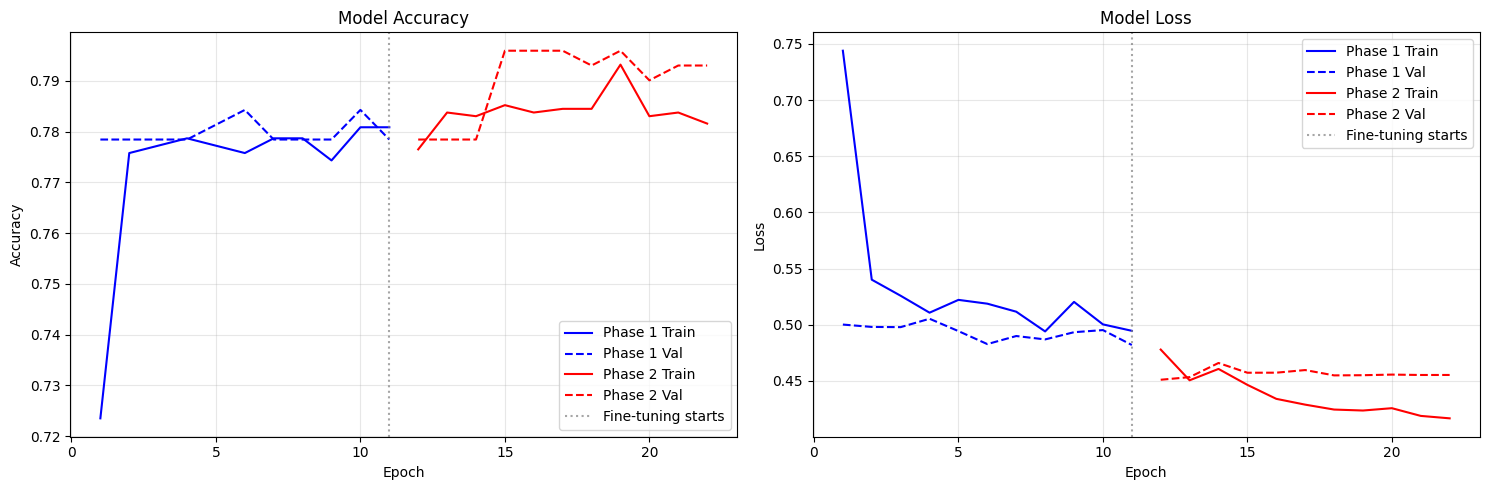

🔍 Evaluating model on validation data...
✅ Final Validation Accuracy: 0.7959
✅ Final Validation Loss: 0.4572

📊 Generating classification report...
11/11 [==============================] - 13s 1s/step


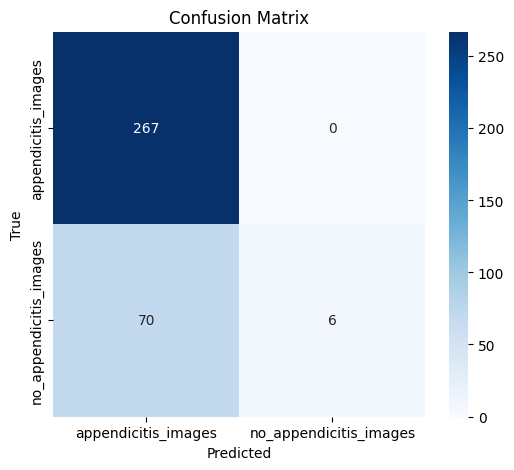

                        precision    recall  f1-score   support

   appendicitis_images       0.79      1.00      0.88       267
no_appendicitis_images       1.00      0.08      0.15        76

              accuracy                           0.80       343
             macro avg       0.90      0.54      0.52       343
          weighted avg       0.84      0.80      0.72       343



In [10]:
# Step 6: Evaluation & Visualization
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history1, history2):
    """Plot accuracy and loss for both training phases."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Epoch indices
    epochs1 = range(1, len(history1.history['accuracy']) + 1)
    epochs2 = range(len(history1.history['accuracy']) + 1,
                   len(history1.history['accuracy']) + len(history2.history['accuracy']) + 1)

    # Accuracy plot
    ax1.plot(epochs1, history1.history['accuracy'], 'b-', label='Phase 1 Train')
    ax1.plot(epochs1, history1.history['val_accuracy'], 'b--', label='Phase 1 Val')
    ax1.plot(epochs2, history2.history['accuracy'], 'r-', label='Phase 2 Train')
    ax1.plot(epochs2, history2.history['val_accuracy'], 'r--', label='Phase 2 Val')
    ax1.axvline(x=len(epochs1), color='gray', linestyle=':', alpha=0.7, label='Fine-tuning starts')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(epochs1, history1.history['loss'], 'b-', label='Phase 1 Train')
    ax2.plot(epochs1, history1.history['val_loss'], 'b--', label='Phase 1 Val')
    ax2.plot(epochs2, history2.history['loss'], 'r-', label='Phase 2 Train')
    ax2.plot(epochs2, history2.history['val_loss'], 'r--', label='Phase 2 Val')
    ax2.axvline(x=len(epochs1), color='gray', linestyle=':', alpha=0.7, label='Fine-tuning starts')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
    ax2.legend(); ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_phase1, history_phase2)


# --- Model Evaluation ---
print("🔍 Evaluating model on validation data...")
val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"✅ Final Validation Loss: {val_loss:.4f}")

# --- Confusion Matrix ---
print("\n📊 Generating classification report...")
# True labels
y_true = validation_generator.classes
# Predictions
y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Labels
class_labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))